Реализуем класс KNNClassifier.

In [407]:
import numpy as np
import sklearn
from sklearn import datasets 
from sklearn.neighbors import NearestNeighbors
EPS = 1e-5


class KNNClassifier:
    def __init__(self, k, strategy, metric, weights, test_block_size):
        self.k = k
        self.strategy = strategy
        self.metric = metric
        self.weights = weights
        self.test_block_size = test_block_size
    
    def fit(self, X_train, y_train):
        if self.strategy=="brute" or self.strategy=="ball_tree" or self.strategy=="kd_tree":
            model = NearestNeighbors(self.k, algorithm = self.strategy, metric = self.metric)
        else:
            self.y_train = y_train
            self.X_train = X_train
            return
        
        self.nbrs = model.fit(X_train, y_train)
        self.y_train = y_train
        return
    
    def find_kneighbors(self, X_test, return_distance):
        if self.strategy=="brute" or self.strategy=="ball_tree" or self.strategy=="kd_tree":
            self.distances, self.indeces = self.nbrs.kneighbors(X_test)
        else:
            if self.metric == 'euclidean':
                distances = euclidean_distance(X_test, self.X_train)
            elif self.metric == 'cosine':
                distances = cosine_distance(X_test, self.X_train)
            indeces = np.argpartition(distances, self.k, axis = 1)
            distances = np.take_along_axis(distances, indeces, axis = 1)
            distances = np.delete(distances, np.s_[self.k:], axis=1)
            indeces = np.delete(indeces, np.s_[self.k:], axis=1)
            ind = np.argsort(distances, axis=1)
            self.distances = np.take_along_axis(distances, ind, axis=1)
            self.indeces = np.take_along_axis(indeces, ind, axis=1)
            if(return_distance):
                return self.distances, self.indeces
            else:
                return self.indeces
            
        if(return_distance):
            return self.distances, self.indeces
        else:
            return self.indeces
    
    def predict(self, X_test):
        #_, self.indeces = self.nbrs.kneighbors(X_test)
        if(self.weights == False):
            self.indeces = self.find_kneighbors(X_test, False)
        else:
            self.distances, self.indeces = self.find_kneighbors(X_test, True)
        y_t = []
        C = [0]*len(np.unique(self.y_train))
        for i in range(X_test.shape[0]):
            C = [0]*len(np.unique(self.y_train))
            for j in range(self.k):
                if(self.weights):
                    C[int(self.y_train[self.indeces[i][j]])] += (1/(self.distances[i][j]+EPS))
                else:
                    C[int(self.y_train[self.indeces[i][j]])] += 1
            y_t.append(np.where(C == np.amax(C))[0][0])
        y_t = np.array(y_t)
        return y_t

Напишем подсчет метрик.

In [220]:
def euclidean_distance(x, y):
    x_sqr_norms = np.array([np.sum(x * x, axis=1)])
    y_sqr_norms = np.array([np.sum(y * y, axis=1)])
    x_y_dot_products = x @ y.T
    dist = x_sqr_norms.T - 2 * x_y_dot_products + y_sqr_norms
    return np.sqrt(dist)
def cosine_distance(x, y):
    x_sqr_norms = np.array([np.linalg.norm(x, axis=1)])
    y_sqr_norms = np.array([np.linalg.norm(y, axis=1)])
    x_y_dot_products = x.dot(y.T)
    
    cos_dist = x_y_dot_products / x_sqr_norms.T /y_sqr_norms
    return 1 - cos_dist

Скачаем датасет.

In [2]:
X, y = datasets.fetch_openml('mnist_784', version=1, return_X_y=True)

In [365]:
y = y.astype(int)

Проверим работу класса KNNClassifier.

In [408]:
clf = KNNClassifier(12, "my_own", "euclidean", True, 100)

In [409]:
clf.fit(X[20:1000],y[20:1000])
clf.predict(X[10:20])

array([3, 5, 3, 6, 1, 7, 7, 8, 6, 9], dtype=int64)

In [7]:
import matplotlib.pyplot as plt

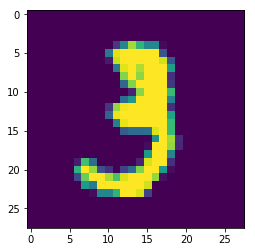

In [411]:
plt.imshow(X[10:20][0].reshape(28,28))

Алгоритм выдает адекватные результаты. 

Напишем метрику accuracy.

In [176]:
def accuracy(Y,y):
    return (np.where(Y.astype(int) == y.astype(int))[0].shape[0])/float(len(y))

Реализуем кросс-валидацию.

In [217]:
from sklearn.model_selection import KFold

def knn_cross_val_score(X, y, k_list, score, cv=None, **kwargs):
    scores_dict = {}
    
    if cv == None:
        folds = KFold(n_splits=3)
        for k in k_list:
            a = KNNClassifier(k, **kwargs)
            scores_list = []
            for train_index, test_index in folds.split(X):
                a.fit(X[train_index],y[train_index])
                Y = a.predict(X[test_index])
                score = accuracy(Y,y[test_index])
                scores_list.append(score)
            scores_dict[f"{k}"] = scores_list
        return scores_dict
              
    
    for k in k_list:
        a = KNNClassifier(k, **kwargs)
        scores_list = []
        for i in cv:
            a.fit(X[i[0]],y[i[0]])
            Y = a.predict(X[i[1]])
            score = accuracy(Y,y[i[1]])
            scores_list.append(score)
        scores_dict[f"{k}"] = scores_list
    return scores_dict

In [243]:
cv = np.array([(np.array(list(range(1600))), np.array(list(range(1600,2000)))), 
               (np.array(list(range(1200))+list(range(1600,2000))), np.array(list(range(1200, 1600)))),
               (np.array(list(range(800))+list(range(1200,2000))), np.array(list(range(800, 1200))))])

In [229]:
import time as t

Найдем с помощью кросс-валидации значения гиперпараметров и оценим время работы. Выведем для каждого значения гиперпараметров результаты на кросс-валидации:

In [265]:
times_euclidean = []
cross_val_scores_euclidean = []
for k in range(1,11):  
    time = t.time()
    cross_val_scores_euclidean.append(knn_cross_val_score(X[0:2000], y[0:2000], [k], accuracy,
                    cv=None, **{"strategy": "My_own", "metric": "euclidean", "weights": False, "test_block_size": 100}))
    times_euclidean.append(t.time()- time)

In [266]:
cross_val_scores_euclidean

[{'1': [0.8905547226386806, 0.8755622188905547, 0.8993993993993994]},
 {'2': [0.8725637181409296, 0.8575712143928036, 0.8723723723723724]},
 {'3': [0.881559220389805, 0.8650674662668666, 0.8888888888888888]},
 {'4': [0.881559220389805, 0.8740629685157422, 0.8813813813813813]},
 {'5': [0.8830584707646177, 0.8680659670164917, 0.8768768768768769]},
 {'6': [0.8755622188905547, 0.8545727136431784, 0.8663663663663663]},
 {'7': [0.8740629685157422, 0.8575712143928036, 0.8738738738738738]},
 {'8': [0.8680659670164917, 0.8500749625187406, 0.8798798798798799]},
 {'9': [0.8650674662668666, 0.848575712143928, 0.8753753753753754]},
 {'10': [0.8605697151424287, 0.8380809595202399, 0.8693693693693694]}]

In [267]:
times_euclidean

[3.7250354290008545,
 3.8786277770996094,
 3.486677408218384,
 3.377964973449707,
 3.4772591590881348,
 3.3360772132873535,
 3.372981548309326,
 3.348045587539673,
 3.2892041206359863,
 3.5923941135406494]

In [268]:
times_cosine = []
cross_val_scores_cosine = []
for k in range(1,11):  
    time = t.time()
    cross_val_scores_cosine.append(knn_cross_val_score(X[0:2000], y[0:2000], [k], accuracy,
                    cv=None, **{"strategy": "My_own", "metric": "cosine", "weights": False, "test_block_size": 100}))
    times_cosine.append(t.time()- time)

In [269]:
cross_val_scores_cosine

[{'1': [0.904047976011994, 0.8935532233883059, 0.924924924924925]},
 {'2': [0.8980509745127436, 0.8710644677661169, 0.9024024024024024]},
 {'3': [0.9070464767616192, 0.8830584707646177, 0.9054054054054054]},
 {'4': [0.9055472263868066, 0.881559220389805, 0.9039039039039038]},
 {'5': [0.9115442278860569, 0.8740629685157422, 0.8978978978978979]},
 {'6': [0.9100449775112444, 0.881559220389805, 0.9024024024024024]},
 {'7': [0.8995502248875562, 0.8785607196401799, 0.9009009009009009]},
 {'8': [0.8935532233883059, 0.8755622188905547, 0.9024024024024024]},
 {'9': [0.8935532233883059, 0.8800599700149925, 0.8978978978978979]},
 {'10': [0.8920539730134932, 0.8695652173913043, 0.9009009009009009]}]

In [270]:
times_cosine

[3.786388397216797,
 3.3041634559631348,
 3.429830551147461,
 3.1944546699523926,
 3.2782671451568604,
 3.3420307636260986,
 3.2692575454711914,
 3.246316909790039,
 3.1914660930633545,
 3.1535661220550537]

In [271]:
times_weights_False = []
cross_val_scores_weights_False = []
for k in range(1,11):  
    time = t.time()
    cross_val_scores_weights_False.append(knn_cross_val_score(X[0:2000], y[0:2000], [k], accuracy,
                    cv=cv, **{"strategy": "My_own", "metric": "cosine", "weights": False, "test_block_size": 100}))
    times_weights_False.append(t.time()- time)

D:\Conda\envs\venv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  


In [272]:
cross_val_scores_weights_False

[{'1': [0.9325, 0.91, 0.9075]},
 {'2': [0.9125, 0.8975, 0.9025]},
 {'3': [0.91, 0.9175, 0.905]},
 {'4': [0.91, 0.925, 0.905]},
 {'5': [0.9025, 0.92, 0.905]},
 {'6': [0.9, 0.9175, 0.91]},
 {'7': [0.9025, 0.91, 0.905]},
 {'8': [0.895, 0.915, 0.9025]},
 {'9': [0.9, 0.915, 0.89]},
 {'10': [0.8975, 0.92, 0.9]}]

In [273]:
times_weights_False

[2.706763982772827,
 2.462411642074585,
 2.514277458190918,
 2.5362205505371094,
 2.4803688526153564,
 2.4794046878814697,
 2.4206464290618896,
 2.3916027545928955,
 2.459529399871826,
 2.4314985275268555]

In [274]:
times_weights_True = []
cross_val_scores_weights_True = []
for k in range(1,11):
    time = t.time()
    cross_val_scores_weights_True.append(knn_cross_val_score(X[0:2000], y[0:2000], [k], accuracy,
                    cv=cv, **{"strategy": "My_own", "metric": "cosine", "weights": True, "test_block_size": 100}))
    times_weights_True.append(t.time()- time)

D:\Conda\envs\venv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  


In [275]:
cross_val_scores_weights_True

[{'1': [0.9325, 0.91, 0.9075]},
 {'2': [0.9325, 0.91, 0.9075]},
 {'3': [0.9225, 0.93, 0.9125]},
 {'4': [0.92, 0.935, 0.915]},
 {'5': [0.9075, 0.92, 0.9125]},
 {'6': [0.915, 0.9225, 0.9]},
 {'7': [0.9125, 0.92, 0.9125]},
 {'8': [0.9175, 0.92, 0.91]},
 {'9': [0.91, 0.92, 0.905]},
 {'10': [0.91, 0.92, 0.8975]}]

In [276]:
times_weights_True

[2.506295919418335,
 2.591137170791626,
 2.5521748065948486,
 2.340742588043213,
 2.6409354209899902,
 2.34173846244812,
 2.3985862731933594,
 2.3277747631073,
 2.4494502544403076,
 2.3706605434417725]

In [294]:
cross_val_scores_weights_True_means = []
for k in range(10):
    mean = np.mean(list(cross_val_scores_weights_True[k].values())[0])
    cross_val_scores_weights_True_means.append(mean)

In [312]:
np.max(cross_val_scores_weights_True_means)

0.9233333333333333

In [299]:
np.where(cross_val_scores_weights_True_means == np.max(cross_val_scores_weights_True_means))[0][0]+1

4

In [301]:
cross_val_scores_weights_False_means = []
for k in range(10):
    mean = np.mean(list(cross_val_scores_weights_False[k].values())[0])
    cross_val_scores_weights_False_means.append(mean)

In [313]:
np.max(cross_val_scores_weights_False_means)

0.9166666666666666

In [302]:
np.where(cross_val_scores_weights_False_means == np.max(cross_val_scores_weights_False_means))[0][0]+1

1

Видно, что лучшими гиперпараметрами для алгоритма являются: k =4, metric = cosine, weghts = True.

In [380]:
model = KNNClassifier(4, "My_own", "cosine", True, 100)

In [381]:
model.fit(X[:2000],y[:2000])

In [386]:
Y = model.predict(X[2000:2500])

In [387]:
accuracy(y[2000:2500], Y)

0.934

Результат даже немного лчше, чем на кросс-валидации. Скорее всего, это произошло благодаря увеличению обучающей выборки.
Таким образом, размер обучающей выборки имеет большое значение. 

Отрисуем несколько неправильных результатов.

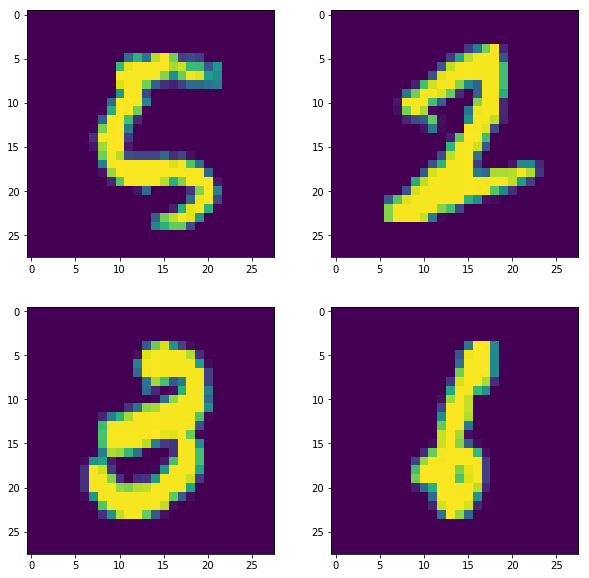

In [426]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

for i,j in enumerate(np.where(y[2000:2500] != Y)[0][:4]):
    axs[i // 2, i % 2].imshow(X[2000:2500][j].reshape(28,28))

Можно видет, что эти цифры, действительно, сильно искажены. 

Орисуем confusion matrix.

In [396]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

In [401]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        1#print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

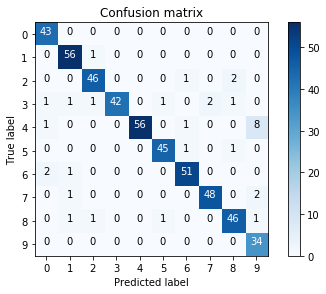

In [405]:
cnf_matrix = confusion_matrix(y[2000:2500], Y)
np.set_printoptions(precision=2)

class_names = list(range(10))
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()

По confusion matrix можно заменить, что самой большой трудностью для алгоритма является отделение четверки от девятки. 